# Assignment 3

Suggested due date: 24th October 2018

## Convolutional neural network

The aims for this assignment are:
* Implement a CNN classifier in Tensorflow
* Experiment with batch normalisation, dropout and residual connections

This assignment follows directly from last week’s assignment. We will build a convolutional neural network (CNN) classifier on the MNIST dataset.

## MNIST CNN classifier

You will have already downloaded the MNIST dataset, and trained an MLP classifier for last week’s assignment. You should also have recorded the network’s performance on the training and test sets, have an estimate for the number of parameters used and recorded the training time. For this week we will train a CNN on the same task and compare it to the MLP on all these benchmarks.

Recall the MNIST dataset consists of 28x28 grayscale images, with associated labels for which digit the image contains (0-9). The training set consists of 60,000 examples and the test set is 10,000 examples.

For the MLP, we flattened the inputs so the images were represented as 784-length vectors, and fed them through several dense layers, resulting in a final softmax layer to predict the digit. Note that this architecture disregards the spatial structure of the inputs, and is inefficient in terms of parameters. 

We exploit the CNN architecture to introduce an _infinitely strong prior_ into the network construction, which asserts the importance of local feature extraction and equivariant representations. 

In this week’s lecture we covered several standard ConvNet architectures, which should serve as inspiration for your own network design. The output of your network should again be a 10-way softmax layer to predict the digit label.

## Implementation in Tensorflow

The assignment is to implement the CNN classifier for MNIST in Tensorflow, train it and test the classification performance on the test set. You should choose the number and types of layers in the network (try testing a few options).

* We recommend to use the ```tf.layers.conv2d``` function for the convolutional layers in the network (but cf. with the lower-level ```tf.nn.conv2d```)
* Similarly, consider using ```tf.layers.max_pooling2d``` and ```tf.layers.dropout``` in your network
* As before, use the ```tf.nn.sparse_softmax_cross_entropy_with_logits_v2``` to compute the loss
* Follow the design principles of the architectures covered in the lecture: build blocks of convolutional and pooling layers, with batch normalisation
* Use either fully connected layers leading to a softmax output at the backend of the network, or implement a global pooling layer (as in GoogLeNet / ResNet)
* Watch out for the dependencies in Tensorflow when using batch normalisation, and also the mode (training/inference)
* As before, record and document the learning curves (train & test loss vs training iterations or epochs), and report the final train and test loss. 
* Calculate the number of parameters used in the network, and record the time required to train the network
* Try to beat your own MLP implementation on the same task! Compare the above benchmarks to your MLP network


In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import matplotlib.pyplot as plt
import numpy as np

In [413]:
# Load the MNIST dataset

set_train = torchvision.datasets.MNIST("data/MNIST", download=True, train=True, transform=torchvision.transforms.ToTensor())
set_test = torchvision.datasets.MNIST("data/MNIST", train=False, transform=torchvision.transforms.ToTensor())

loader_train = torch.utils.data.DataLoader(set_train, batch_size=128)
loader_test = torch.utils.data.DataLoader(set_test, batch_size=1)

In [369]:
# Build our model (naieve CNN with some pooling)
class CNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 8, 9),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 4),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        self.lin = nn.Sequential(
            nn.BatchNorm1d(32),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 10),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = self.conv(x)
        return self.lin(x.view(-1, 32))    

tensor(2)


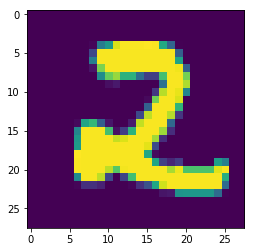

In [370]:
# Display some image
idx = np.random.choice(np.arange(len(set_train)))
img = set_train[idx][0]

print(set_train[idx][1])
plt.imshow(img.squeeze())
plt.show()

# model = CNN()
# model.eval()
# print(model(img.unsqueeze(0)))

In [371]:
from IPython.display import clear_output

def show_graph(losses, epoch):
    clear_output(wait=True)
    plt.plot(losses)
    plt.title("Epoch: {}".format(epoch))
    plt.show()

In [372]:
# Now, train using Adam and binary cross entropy loss
def loss_fn(pred, target):
    return F.cross_entropy(pred, target, reduction="elementwise_mean")

model = CNN()
loss_train = []

adam = torch.optim.Adam(model.parameters(), lr=1e-3)


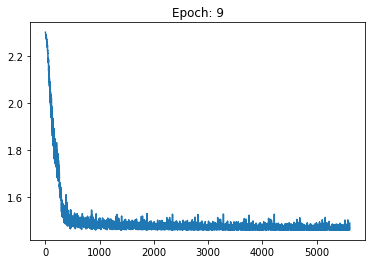

DONE!


In [376]:
model.train()

for epoch in range(10):
    for batch_idx, (x, y) in enumerate(loader_train):
        adam.zero_grad()
        pred = model(x)
        l = loss_fn(pred, y)
        loss_train.append(l.item())
        l.backward()
        adam.step()
        if batch_idx % 50 == 0:
            show_graph(loss_train, epoch)
print("DONE!")

In [377]:
# Test the model accuracy on the test data
model.eval()
correct = 0
incorrect = 0

with torch.no_grad():
    for _, (x, y) in enumerate(loader_test):
        pred = model(x).squeeze()
        if torch.argmax(pred) == y:
            correct += 1
        else:
            incorrect += 1

print(correct, incorrect)
print("Correct: {:.2f}%".format(correct/(correct+incorrect)*100))

# BEAT: 191, 189, 134

9866 134
Correct: 98.66%


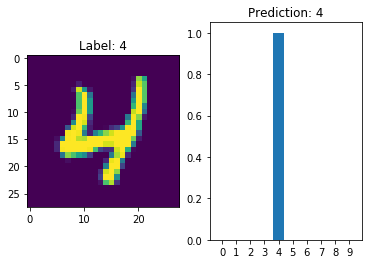

In [428]:
# Visualize predictions
import random as rand
idx = rand.randint(0, len(set_test)-1)
img = set_test[idx][0]
label = set_test[idx][1]

with torch.no_grad():
    model.eval()
    pred = model(img.unsqueeze(0)).squeeze()

    _, ax = plt.subplots(1, 2)
    ax[0].imshow(img.squeeze())
    ax[0].set_title("Label: {}".format(label.item()))
    ax[1].bar(range(10), pred)
    ax[1].set_xticks(range(10))
    ax[1].set_title("Prediction: {}".format(torch.argmax(pred)))

In [429]:
# Number of parameters
param_num = 0
for param in model.parameters():
    param_num += torch.prod(torch.tensor(param.size())).item()
print("# of parameters:", param_num)

# of parameters: 10922
